In [51]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
"""
    accuracy_score used to calculate the accuracy of either the faction or count of correct prediction in Python Scikit learn.
    Compute the F1 score, also known as balanced F-score or F-measure.
    
    The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
    The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
    The best value is 1 and the worst value is 0.
    
    The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
    The recall is intuitively the ability of the classifier to find all the positive samples.
    The best value is 1 and the worst value is 0.
    
    The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches 
    its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
    
    This metric is calculated as:
    F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
"""

from sklearn.metrics import classification_report, confusion_matrix
"""
    classification_report builds a text report showing the main classification metrics. 
    confusion_matrix computes confusion matrix to evaluate the accuracy of a classification.
"""

""" 
    Itertools is a module in python, it is used to iterate over data structures that can be stepped over using a 
    for-loop. Such data structures are also known as iterables.
"""
import itertools

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df=pd.read_excel('../data/Constraint_Train.xlsx')
df.head(5)

id                                              tweet label
0  1.0  The CDC currently reports 99031 deaths. In gen...  real
1  2.0  States reported 1121 deaths a small rise from ...  real
2  3.0  Politically Correct Woman (Almost) Uses Pandem...  fake
3  4.0  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4  5.0  Populous states can generate large case counts...  real

In [3]:
#df.groupby('Category').describe()

In [4]:
#df['Category'].value_counts()

In [5]:
#747/4825

In [6]:
df_fake = df[df['label']=='fake']
df_fake.shape

(3060, 3)

In [7]:
df_real = df[df['label']=='real']
df_real.shape

(3360, 3)

In [8]:
df_real_downsampled = df_real.sample(df_fake.shape[0])
df_real_downsampled.shape

(3060, 3)

In [9]:
df_balanced = pd.concat([df_real_downsampled, df_fake])
df_balanced.shape

(6120, 3)

In [10]:
df_balanced['label'].value_counts()

real    3060
fake    3060
Name: label, dtype: int64

In [11]:
df_balanced['fake']=df_balanced['label'].apply(lambda x: 1 if x=='fake' else 0)
df_balanced.sample(5)

id                                              tweet label  fake
5869  5870.0  Indian nurses resigned due to COVID-19 infecte...  fake     1
5453  5454.0  COVID-19 patients will not show symptoms for t...  fake     1
876    877.0  The government is changing the rules around se...  real     0
922    923.0  Such high level of testing will also lead to h...  real     0
6197  6198.0  Multiple posts on Facebook and Twitter claim t...  fake     1

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['tweet'],df_balanced['fake'], stratify=df_balanced['fake'])

In [13]:
X_train.head(4)

3751    Our daily update is published. We’ve now track...
4337    3 Ways #Healthcare is Using Predictive Analyti...
6007    Researchers claim 100 percent cure rate vs. co...
1722    RT @mediawise: In a pre-COVID world when we tr...
Name: tweet, dtype: object

In [26]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [27]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.9896933 ,  0.94865113,  0.14714397, ...,  0.2550564 ,
        -0.6044689 , -0.06834818],
       [ 0.92811036,  0.9941616 , -0.13627031, ...,  0.55593175,
         0.24712017, -0.6370726 ]], dtype=float32)>

In [32]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [34]:
len(X_train)

4590

In [35]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [ ]:
# model.fit(X_train, y_train, epochs=15,batch_size=64)

In [37]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=2,batch_size=64)

Epoch 1/2
72/72 [==============================] - 362s 5s/step - loss: 0.5170 - accuracy: 0.7540 - precision: 0.7707 - recall: 0.7233 - val_loss: 0.4264 - val_accuracy: 0.8092 - val_precision: 0.8192 - val_recall: 0.7935
Epoch 2/2
72/72 [==============================] - 360s 5s/step - loss: 0.4047 - accuracy: 0.8248 - precision: 0.8576 - recall: 0.7791 - val_loss: 0.3731 - val_accuracy: 0.8333 - val_precision: 0.8446 - val_recall: 0.8170


In [38]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [39]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
def create_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    to plot a sklearn confusion matrix(cm)

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    """
        Accuracy (all correct / all) = (TP + TN) / (TP + TN + FP + FN)
    """
    
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('YlOrRd') 
    """ 
        To select the colour theme of the confusion matrix
    """

    plt.figure(figsize=(5, 4))
    """
        To create a figure with the given width, height in inches.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    """
       To display data as an image, i.e., on a 2D regular raster.
    """
    
    plt.title(title)
    plt.colorbar()
    """
       To display a title and colorbar on the axes.
    """
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    """
        To put the labels on the confusion matrix, with or without rotation.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    """
        To normalize the confusion matrix by slicing and adding a new axis.
    """


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    """
        To calculate the threshold by finding the maximum value in confusion matrix.
    """
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    """
        To display the values in the confusion matrix with different colours and precision.
    """

    plt.tight_layout()
    """
        This automatically adjusts subplot params so that the subplot(s) fits in to the figure area. 
    """
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    """
        To plot the the labels on their respective axes.
    """
    
    plt.show()
    """
        To show the confusion matix on screen.
    """

In [49]:
def print_metrices(y_predicted,y_test):
    print(confusion_matrix(y_test,y_predicted))
    print(classification_report(y_test,y_predicted,))
    print("Accuracy : ",accuracy_score(y_predicted,y_test))
    print("Precison : ",precision_score(y_predicted,y_test, average = 'weighted'))
    print("Recall : ",recall_score(y_predicted,y_test,  average = 'weighted'))
    print("F1 : ",f1_score(y_predicted,y_test,  average = 'weighted'))
    """
        Here, we are printing the confusion matrix, its accuracy, precision, recall and F1 score.
    """

[[650 115]
 [140 625]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       765
           1       0.84      0.82      0.83       765

    accuracy                           0.83      1530
   macro avg       0.83      0.83      0.83      1530
weighted avg       0.83      0.83      0.83      1530

Accuracy :  0.8333333333333334
Precison :  0.8338673159895766
Recall :  0.8333333333333334
F1 :  0.8333778437719214


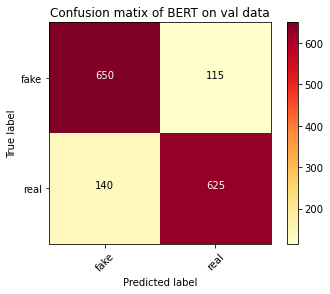

In [50]:
print_metrices(y_predicted,y_test)
create_confusion_matrix(confusion_matrix(y_test,y_predicted),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of BERT on val data')